In [1]:
%run imports.py
import scipy.sparse
from autolssvm import *
from sklearn.datasets.mldata import fetch_mldata
from sklearn.utils.estimator_checks import check_estimator
test_data_home = tempfile.mkdtemp()

In [2]:
pages = 10
dataset_names = []
for page_url in tqdm_notebook(['http://mldata.org/repository/data/by_downloads/?data_page=' + str(i + 1) for i in range(0, pages)]):
    soup = BeautifulSoup(requests.get(page_url).text, 'html.parser')
    dataset_names += [a['href'].replace('/repository/data/viewslug/', '').replace('/', '') for a in soup.select('h2.gallery > a')]
len(dataset_names)

A Jupyter Widget

100

In [3]:
if 'datasets' not in globals():
    datasets = {}
for dataset_name in tqdm_notebook(dataset_names):
    if dataset_name not in datasets:
        try:
            datasets[dataset_name] = fetch_mldata(dataset_name)
        except Exception:
            pass
len(datasets.keys())

A Jupyter Widget

95/|/ 95%|| 95/100 [00:50<00:02,  1.90it/s]                                        


92

In [4]:
datasets = {dataset: datasets[dataset] for dataset in datasets
            if datasets[dataset]['data'].shape[0] > 1 and datasets[dataset]['data'].shape[1] > 1}
len(datasets)

73

In [5]:
def subsample(X, sub_d=4, sub_n=4):
    """Subsample the feature and observation space."""
    for i in range(1, sub_n + 1):
        for j in range(1, sub_d + 1):
            if i == 1 and j == 1:
                yield X 
            else:
                yield X[np.random.choice(X.shape[0], max(1, int(X.shape[0] / i)), replace=False),
                        np.random.choice(X.shape[1], max(1, int(X.shape[1] / j)), replace=False)]


def normalizer(X, one_sided_extrema=0.05, hypercube_edge_length=1.0, max_samples=10000):
    """Compute a robust center and scale parameter."""
    if scipy.sparse.issparse(X):
        idx = np.random.choice(X.shape[0], size=min(max_samples, X.shape[0]), replace=False)
        X = X[idx, :].todense()
    m = np.median(X, axis=0)
    s = np.amax(np.abs(np.percentile(X, [one_sided_extrema, 1.0 - one_sided_extrema], axis=0) - m), axis=0)
    s *= 2. / hypercube_edge_length
    eps = np.finfo(np.float32).eps if X.dtype == np.float32 else np.finfo(np.float64).eps
    s[s <= eps] = 1.0
    return m, s


def nn_dist(X, one_sided_extrema=0.05, hypercube_edge_length=1.0, max_samples=10000):
    """Compute the nearest neighbour distance after robust normalization."""
    # ||a - b||^2 = ||a||^2 + ||b||^2 - 2 a^T b
    # ||(a-m)/s - (b-m)/s||^2 = ||a/s||^2 + ||b/s||^2 - 2(a/s)^T (b/s)
    B = X if X.shape[0] < max_samples else X[np.random.choice(X.shape[0], max_samples, replace=False), :]
    m, s = normalizer(X, one_sided_extrema, hypercube_edge_length, max_samples)
    if scipy.sparse.issparse(X):
        s = scipy.sparse.diags(1. / np.ravel(s), 0)
        A = X @ s
        A2 = A.multiply(A).sum(axis=1)
        B = B @ s
        B2 = B.multiply(B).sum(axis=1)
    else:
        A = X / s
        A2 = (A ** 2).sum(axis=1)[:, np.newaxis]
        B = B / s
        B2 = (B ** 2).sum(axis=1)[:, np.newaxis]
    dist = A2 + (B2.T - 2. * (A @ B.T))
    dist[dist <= 1e-6] = np.inf
    return np.ravel(np.sqrt(np.amin(dist, axis=0)))

In [6]:
from scipy.special import gamma, gammaln, beta, betaln

def ball_volume(d):
    return np.exp((d / 2.) * np.log(np.pi) - gammaln(d / 2. + 1.))

def ball_volume_invdthroot(d):
    return np.exp(-1. / 2. * np.log(np.pi) + gammaln(d / 2. + 1.) / d)

def ball_volume_loginvdthroot(d):
    """Returns log(V**(-1/d)) where V is the volume of a d-dimensional unit ball."""
    return -np.log(np.pi) / 2. + gammaln(d / 2. + 1.) / d

def nn_dist_lb(d, n):
    a = ball_volume_invdthroot(d)
    return a * beta((n + 1.) / 2., 1. / d) / d

def nn_dist_lb(d, n):
    """Returns a lower bound on the expected nearest-neighbour distance of n points uniformly distributed over a d-dimensional hypercube."""
    return np.exp(ball_volume_loginvdthroot(d) + betaln((n + 1.) / 2., 1. / d) - np.log(d))

def nn_dist_ub(d, n):
    b = 4. * ball_volume_invdthroot(d)  # = (ball_volume(d) / 2. ** (2 * d)) ** (-1. / d)
    return b * beta(n * (n - 1.) / 2. + 1., 1. / d) / d

def nn_dist_ub(d, n):
    """Returns an upper bound on the expected nearest-neighbour distance of n points uniformly distributed over a d-dimensional hypercube."""
    return np.exp(np.log(4.) + ball_volume_loginvdthroot(d) + betaln(n * (n - 1.) / 2. + 1., 1. / d) - np.log(d))

n = 10000
d = 300
print(nn_dist_lb(d, n))
print(nn_dist_ub(d, n))

4.1126318224
15.9531568397


In [7]:
def kernel_radius_to_gamma(kernel_radius, n, d, kernel_value_at_radius=0.5):
    nn_dist = nn_dist_lb(d, n) / 2.
    gamma = -np.log(kernel_value_at_radius) / (kernel_radius * nn_dist) ** 2.
    return gamma

kernel_radius_to_gamma(4.0, 100, 1)

1767.6985972229979

In [8]:
np.exp(-441.*(4./100.)**2.)

0.49381219803334614

In [9]:
n = 300000000
d = 300000
beta(n * (n - 1.) / 2. + 1., 1. / d)

299961.07987304084

In [10]:
lb = []
ub = []
dt = []
N  = []
D  = []
for dataset in tqdm_notebook(datasets):
    try:
        n, d = datasets[dataset]['data'].shape
        if (n > 10000) or (d > 10000):
            continue
        dt += [nn_dist(datasets[dataset]['data'])]
        lb += [nn_dist_lb(d, n)]
        ub += [nn_dist_ub(d, n)]
        N  += [n]
        D  += [d]
    except Exception:
        pass

A Jupyter Widget

<IPython.core.display.Javascript object>


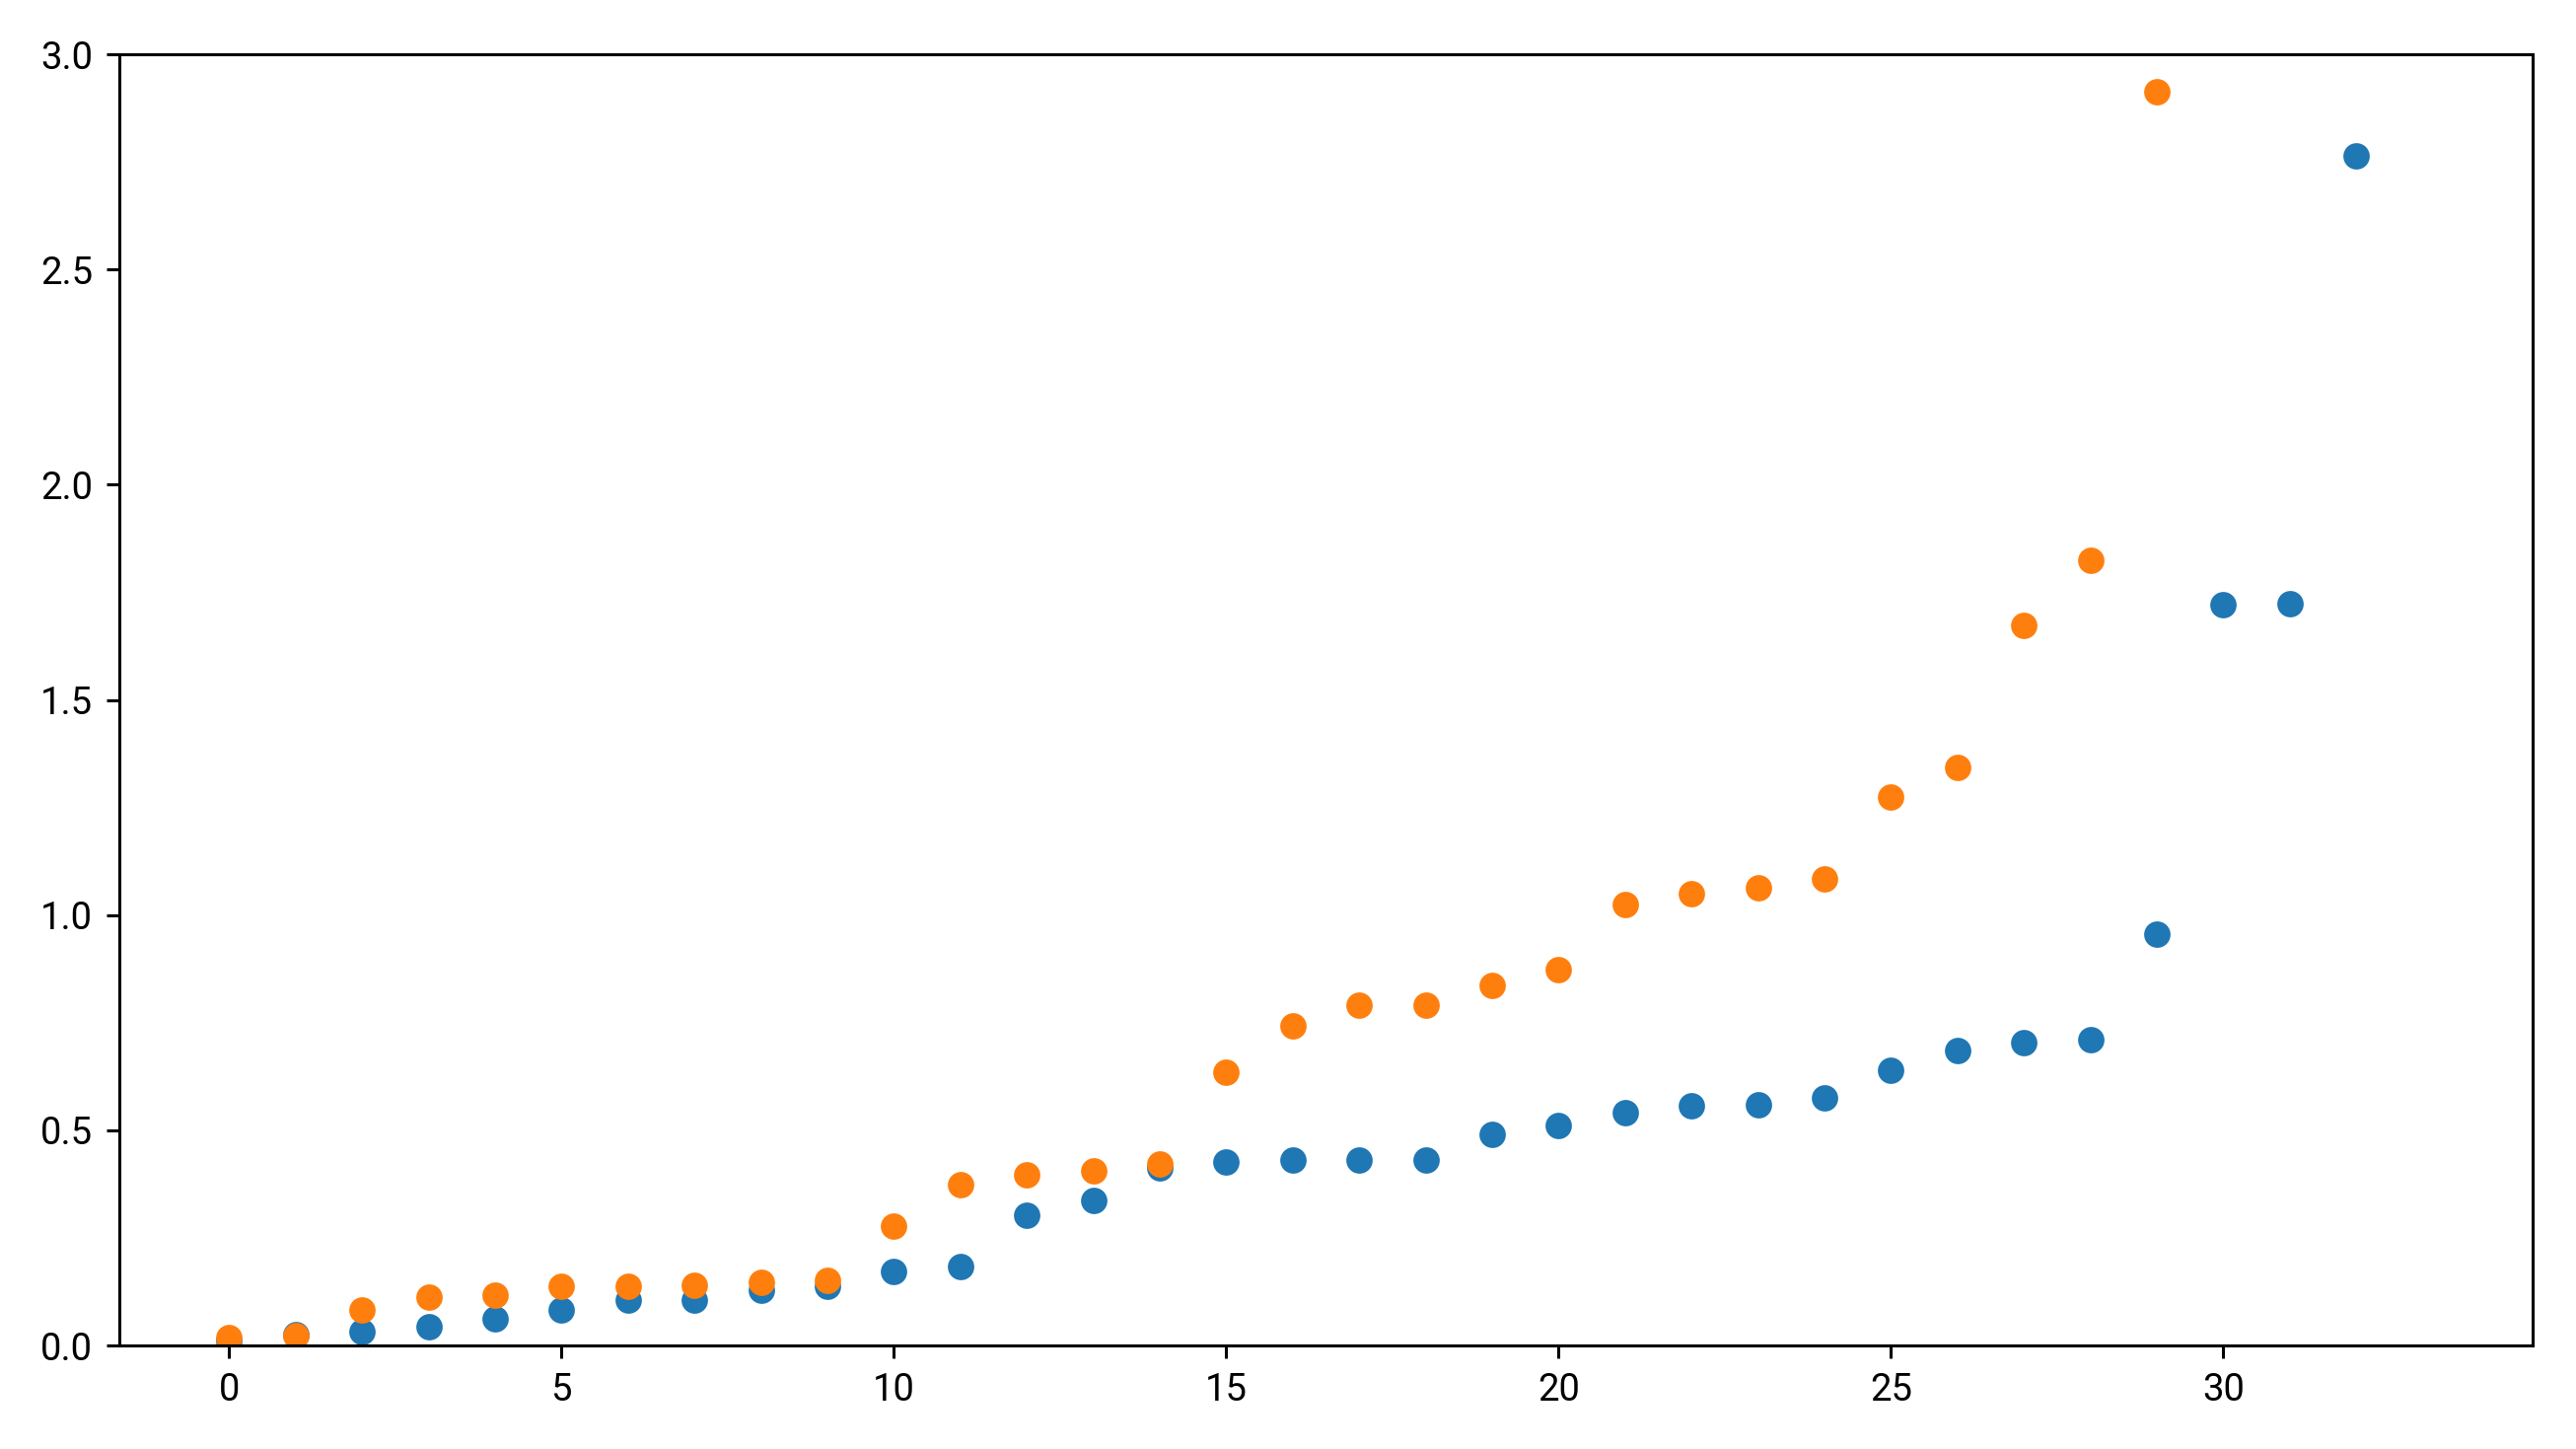

In [12]:
actual = np.array([np.median(a) for a in dt])
plt.plot(sorted(np.abs(actual - np.array(lb) / 2) / actual), 'o');
plt.plot(sorted(np.abs(actual - np.array(lb)) / actual), 'o');
plt.ylim(0,3);

In [13]:
list(zip(list(np.array(lb)/2), list(actual), lb))

[(0.32918076277547959, 1.136979369522471, 0.65836152555095917),
 (1.8933421222102356, 0.5028600269423471, 3.7866842444204711),
 (0.10328250861668072, 0.073144128158711963, 0.20656501723336143),
 (10.216420923009837, 32.583530736971504, 20.432841846019674),
 (1.4900495430892435, 0.288358549999361, 2.9800990861784871),
 (0.00485620024033685, 0.0047973805121627657, 0.0097124004806737),
 (0.15201022454518842, 0.055816254212781906, 0.30402044909037684),
 (0.11544606483958161, 0.23630035613208886, 0.23089212967916323),
 (0.18784666210740977, 0.33001453790959401, 0.37569332421481955),
 (3.8497373263882304, 1.4142135623730951, 7.6994746527764608),
 (0.31622202594604021, 0.23661188556313464, 0.63244405189208042),
 (0.25781332595977358, 0.25, 0.51562665191954715),
 (0.27099437303951085, 0.61030264831399927, 0.5419887460790217),
 (0.013725699332504167, 0.01206651134542152, 0.027451398665008335),
 (0.18374696616849426, 0.41666666666666674, 0.36749393233698852),
 (0.38753492304561382, 0.33068587219

<IPython.core.display.Javascript object>


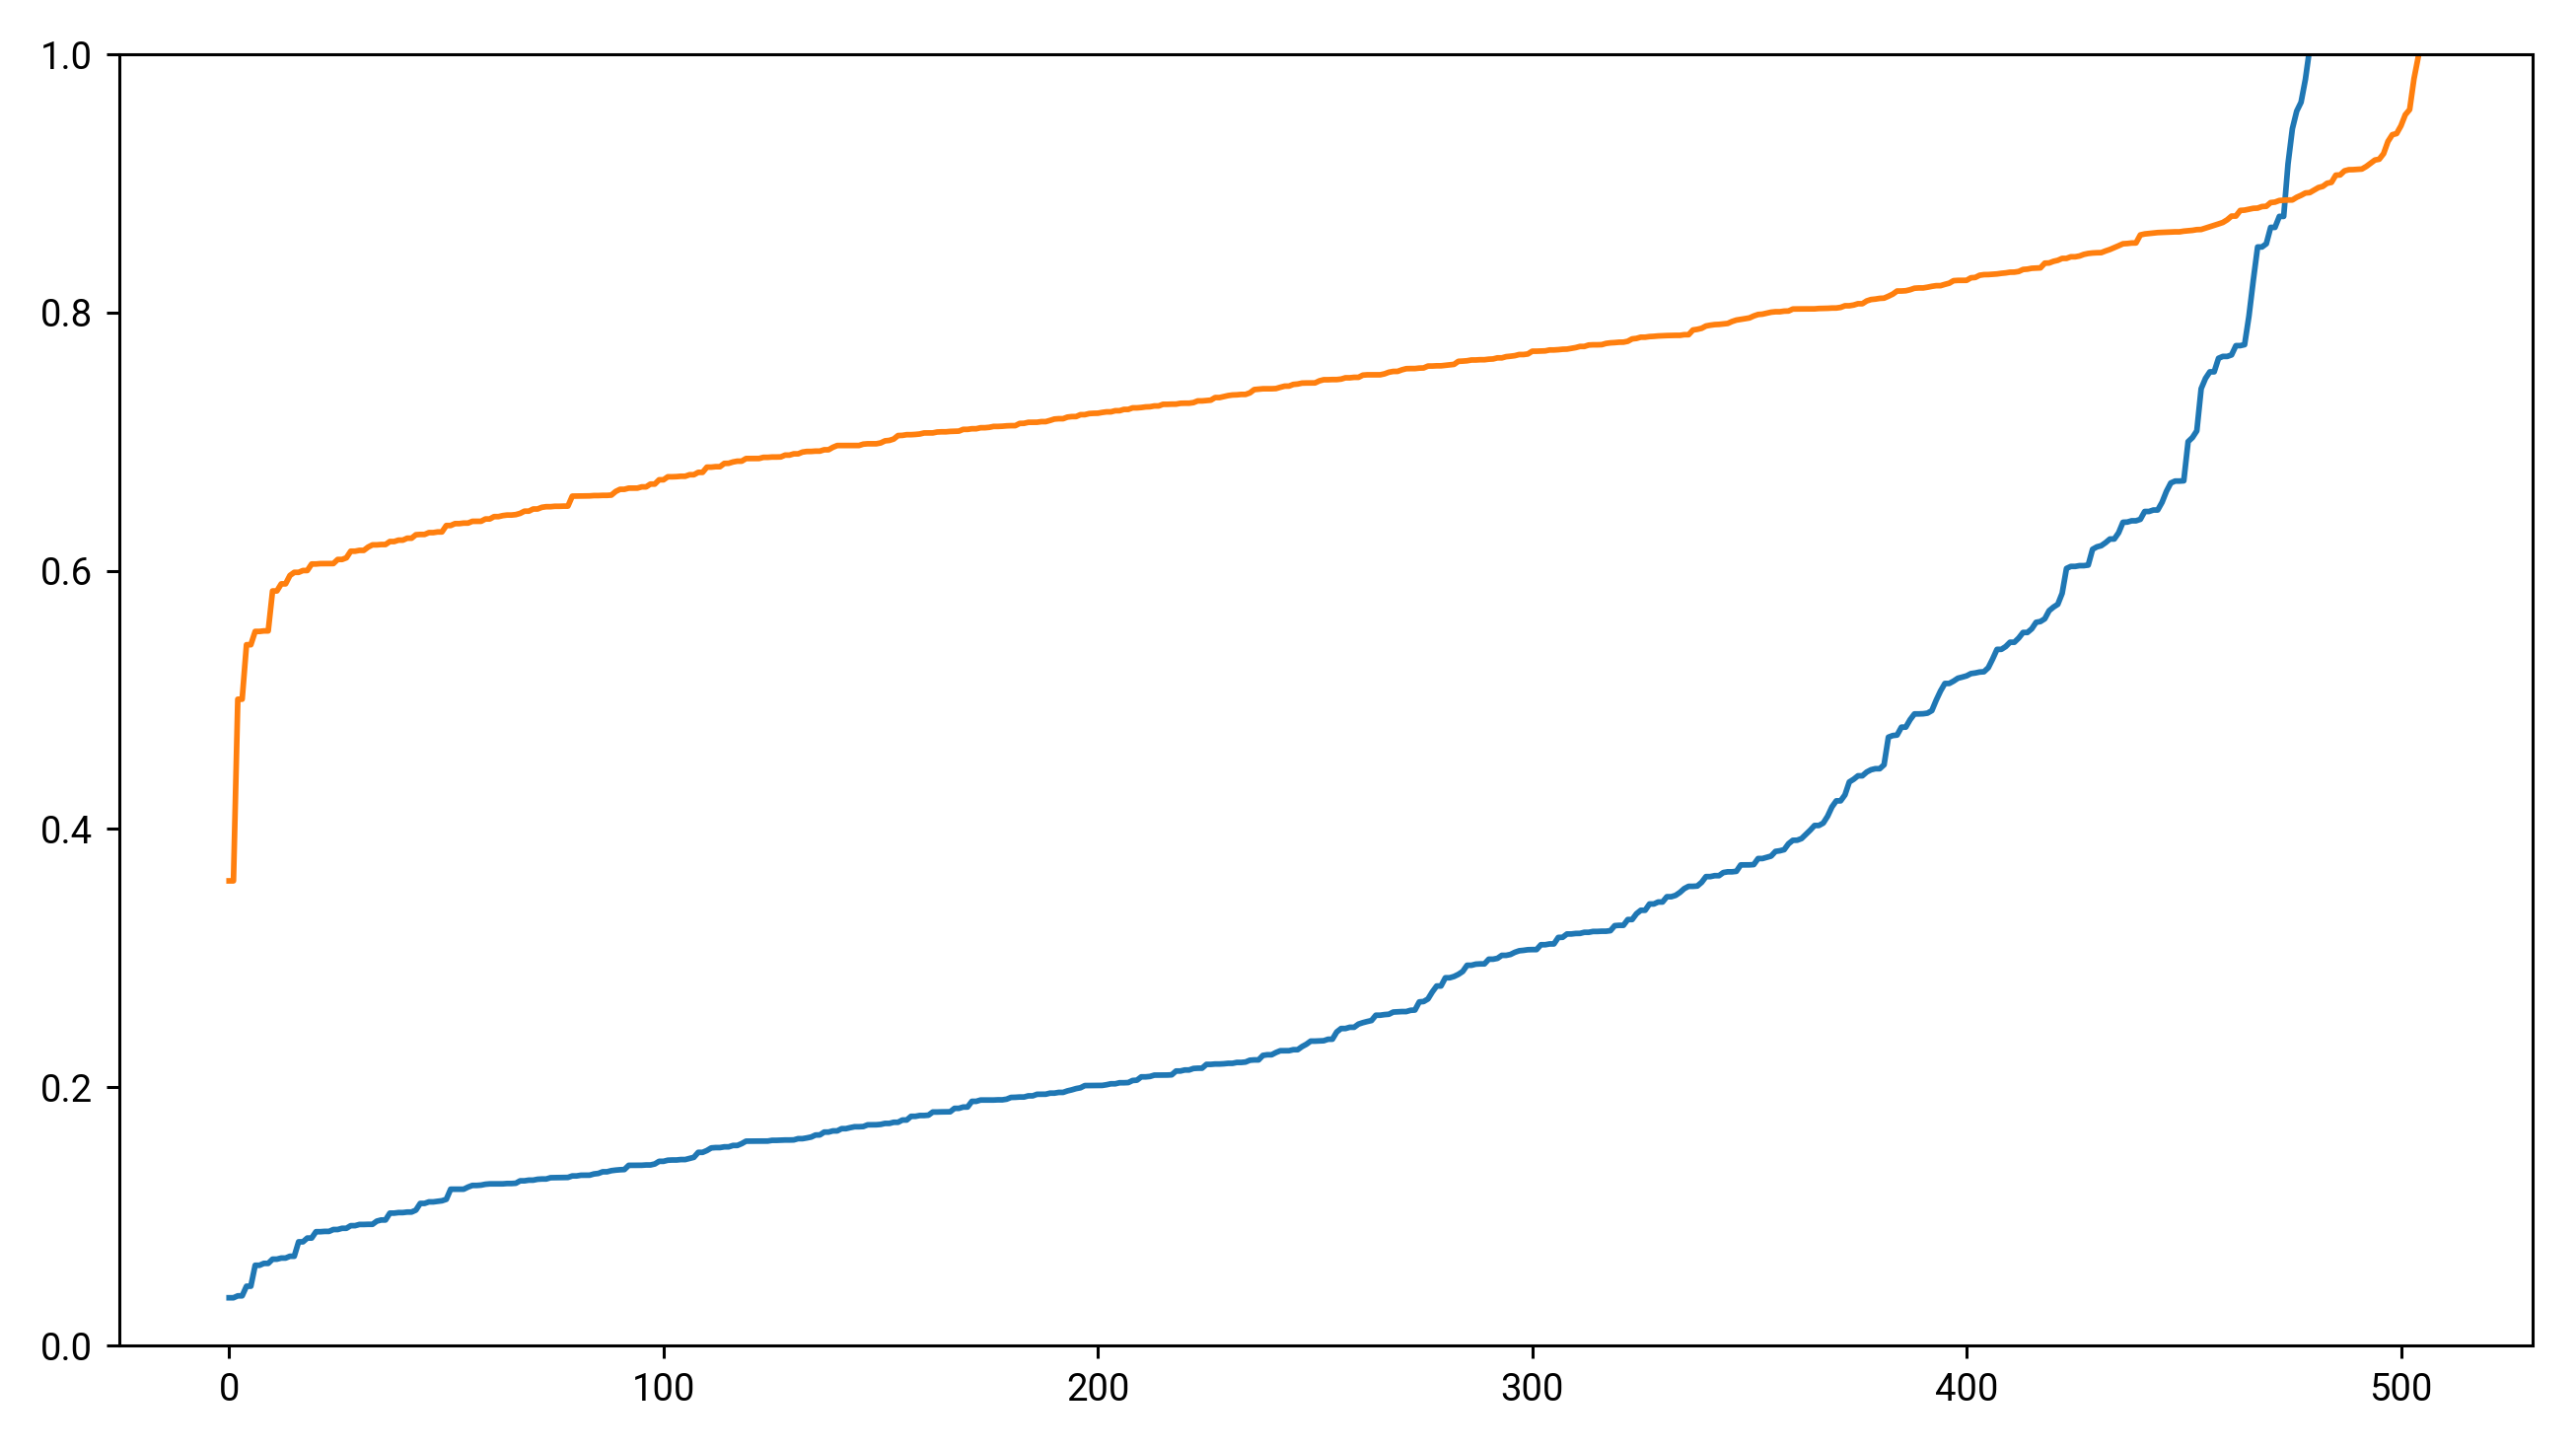

In [16]:
name = 'housing_scale'
A = np.random.rand(*datasets[name]['data'].shape)
plt.plot(sorted(nn_dist(datasets[name]['data'])));
plt.plot(sorted(nn_dist(A)));
plt.ylim(0, 1);

In [17]:
datasets[name]['data'].shape

(506, 13)

In [18]:
dataset_names

['mnist-original',
 'australian',
 'chars74k-english-img',
 'usps',
 'sensit-vehicle-combined',
 'iris',
 'translation-initiation-site-pred',
 'leukemia',
 'datasets-uci-iris',
 'jester-2',
 'book-crossing-ratings-10',
 'colon-cancer-kent-ridge',
 'mkl-toy',
 'stockvalues',
 'ovarian-cancer-nci-pbsii-data',
 'central-nervous-system',
 'covtypebinary',
 'global-earthquakes',
 'dlbcl-outcome-from-harvard',
 'biocreative-iii-ppi-act-dataset',
 'worldwide-companies-r10k',
 'poker',
 'banana-ida',
 'breast-cancer-kent-ridge-2',
 'yahoo-web-directory-topics',
 'cod-rna',
 'abalone',
 'jester-1',
 'dlbcl-tumor-from-harvard',
 'artificial-2state-sequence-data',
 'lung-cancer-michigan',
 'record-of-heart-sound',
 'regression-datasets-housing',
 'diabetes_scale',
 'mnist',
 'asap_toy',
 'datasets-uci-mushroom',
 'news20binary',
 'dmoz-web-directory-topics',
 'housing_scale',
 'dlbcl-nih',
 'flare-solar-ida',
 'covtype',
 'lung-cancer-ontario',
 'datasets-uci-breast-cancer',
 'whistler-daily-snow

<IPython.core.display.Javascript object>


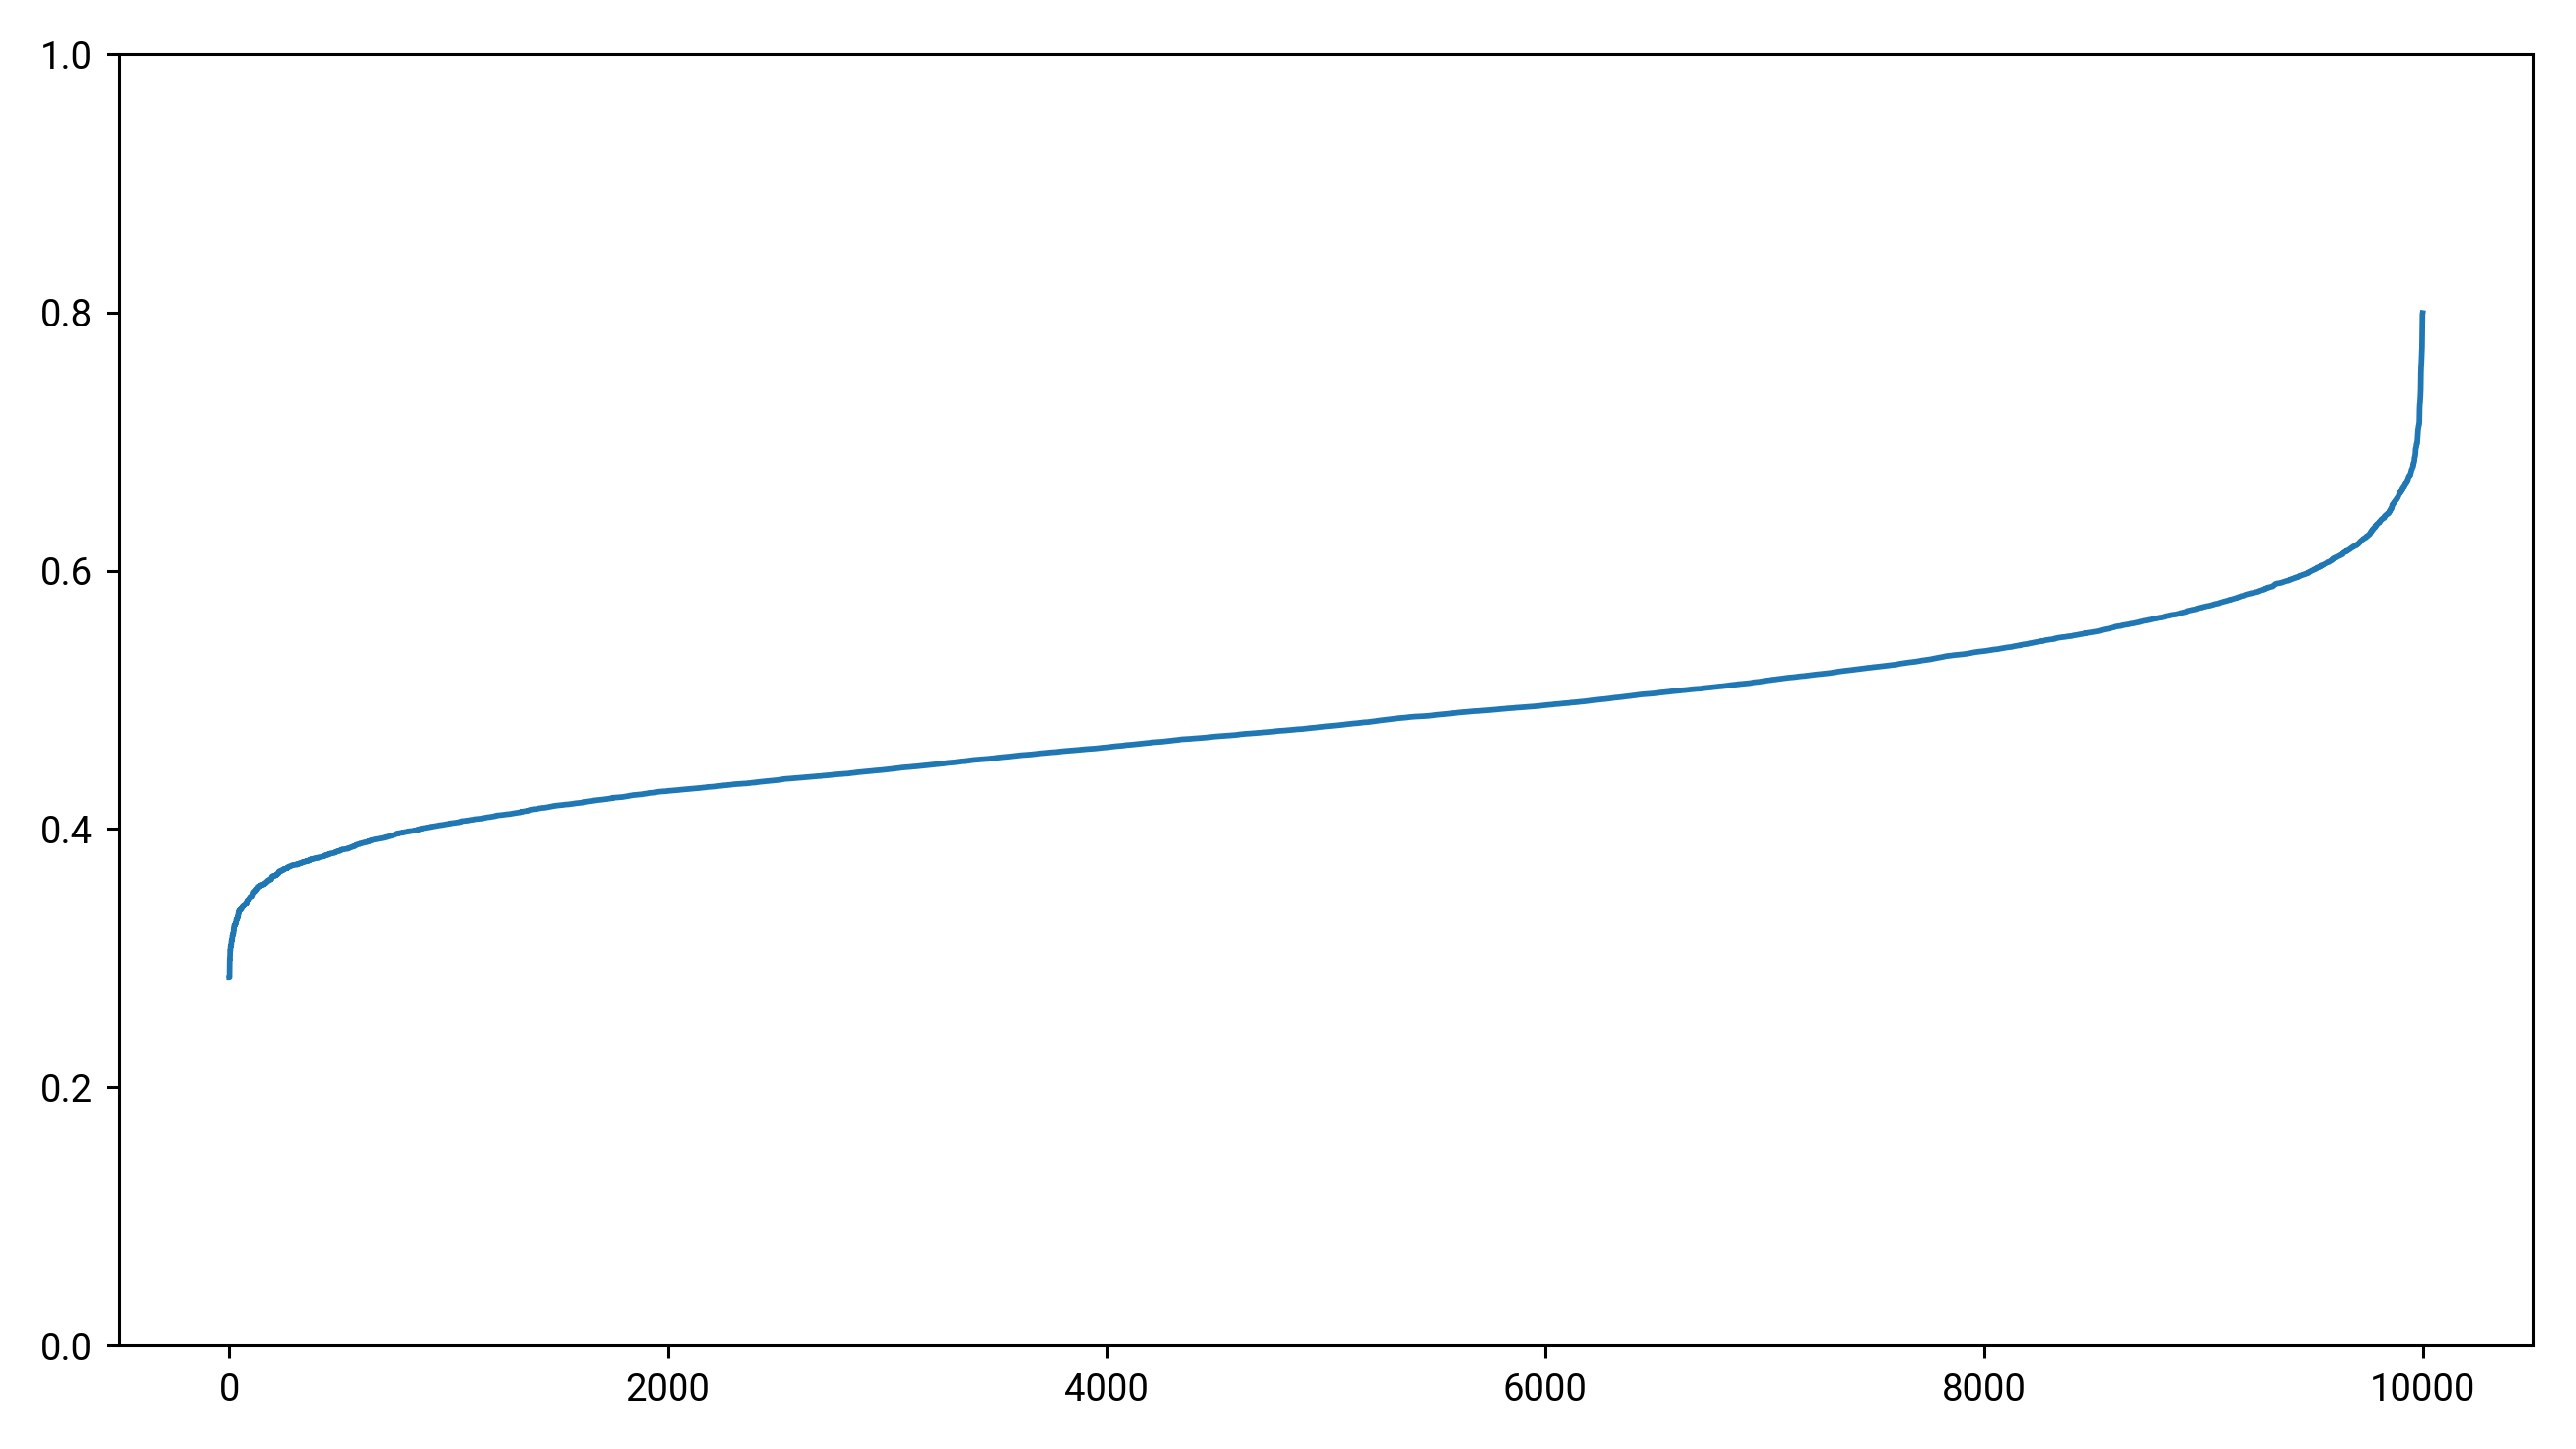

In [19]:
A = np.random.randn(10000, 20)
A = scipy.sparse.csr_matrix(A)
#A = np.array([[1,2],[3,4],[5,6]])
#A = scipy.sparse.csr_matrix(A)
plt.plot(sorted(nn_dist(A)))
#plt.plot(sorted(nn_dist(A + 1.)))
#plt.plot(sorted(nn_dist(A + 2.)))
plt.ylim(0, 1);

<IPython.core.display.Javascript object>


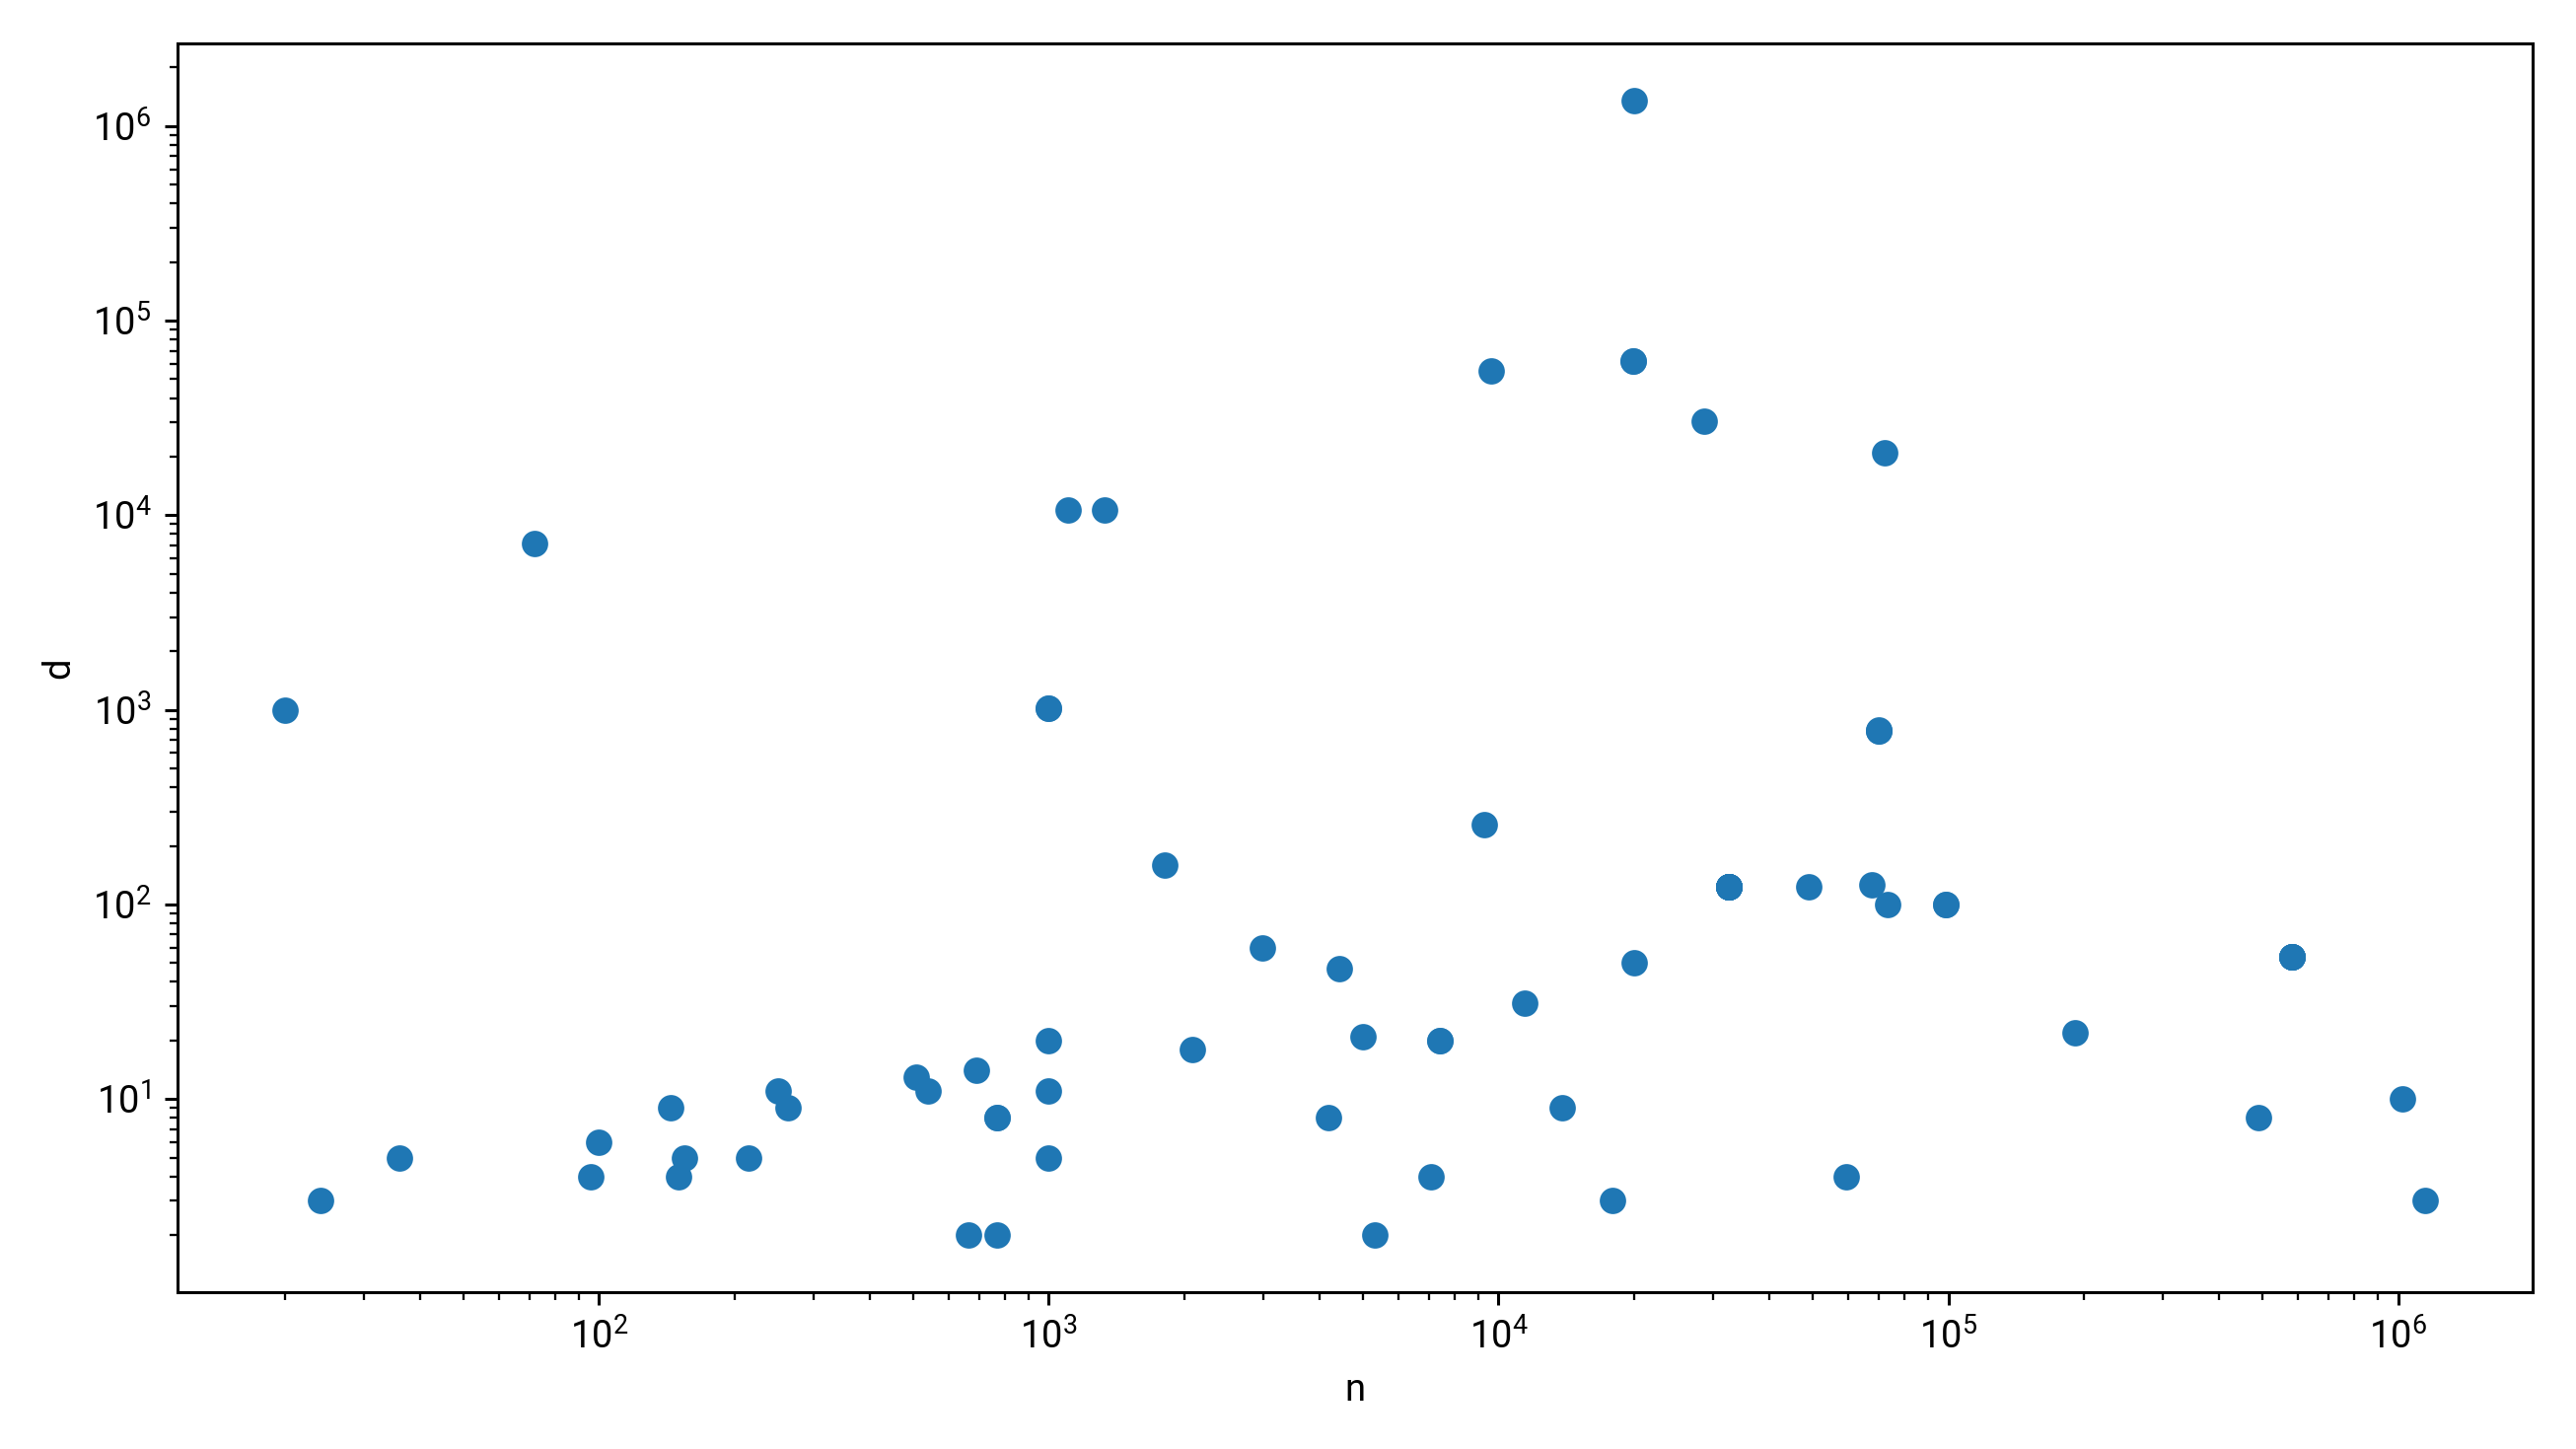

In [21]:
n = [dataset['data'].shape[0] for dataset in datasets.values()]
d = [dataset['data'].shape[1] for dataset in datasets.values()]
plt.loglog(n, d, 'o');
plt.xlabel('n');
plt.ylabel('d');

In [22]:
datasets = [
    'news20.binary',                    # 1.3M features
    'news20_scale',                     #  62k features
    'siam-competition2007',             #  30k features
    'Breast Cancer (Kent Ridge) 2',     #  24k features
    'Ovarian Cancer (NCI PBSII Data)',  #  15k features
    'Central Nervous System',           #   7k features
    'Diffuse Large B-Cell (Stanford)',  #   4k features
    'Drug-datasets mtp2',               #   1k features
    'MNIST (original)',                 #  800 features
    'scene-classification',             #  300 features
    'dna',                              #  180 features
    'stockvalues',                      #  160 features
    'SensIT Vehicle (combined)_scale',  #  100 features
    'sonar',                            #   61 features
    'uci-20070111 water-treatment',     #   39 features
]
data = {}
for dataset in tqdm_notebook(datasets):
    if dataset not in data:
        data[dataset] = fetch_mldata(dataset)

A Jupyter Widget

In [23]:
def compute_normalizer(X, one_sided_extrema, hypercube_edge_length):
    if scipy.sparse.issparse(X):
        idx = np.random.randint(X.shape[0], size=min(int((10000*10000) / X.shape[1]), 10000))
        X = X[idx, :].todense()
    m = np.median(X, axis=0)
    s = np.amax(np.abs(np.percentile(X - m, [one_sided_extrema, 1.0 - one_sided_extrema], axis=0)), axis=0)
    s /= (hypercube_edge_length / 2.)
    eps = np.finfo(np.float32).eps if X.dtype == np.float32 else np.finfo(np.float64).eps
    if np.isscalar(s):
        s = 1.0 if s <= eps else s
    else:
        s[s <= eps] = 1.0
    return m, s

def apply_normalizer(X, m, s):
    X = X - m
    X /= s
    return X

def pairwise_distance_distribution(X, samples=None, one_sided_extrema=0.075, hypercube_edge_length=0.5):
    if samples is None:
        samples = min(int((10000*10000) / X.shape[1]), 10000)
    m, s = compute_normalizer(X, one_sided_extrema=one_sided_extrema, hypercube_edge_length=hypercube_edge_length)
    idx = np.random.randint(X.shape[0], size=(samples, 2))
    A = (X[idx[:, 0], :] - m) / s
    B = (X[idx[:, 1], :] - m) / s
    return np.linalg.norm(A - B, axis=1)


In [ ]:
dist = {}
for dataset in tqdm_notebook(datasets):
    if dataset not in ['Central Nervous System']:
        dist[dataset] = pairwise_distance_distribution(data[dataset]['data'])

<IPython.core.display.Javascript object>


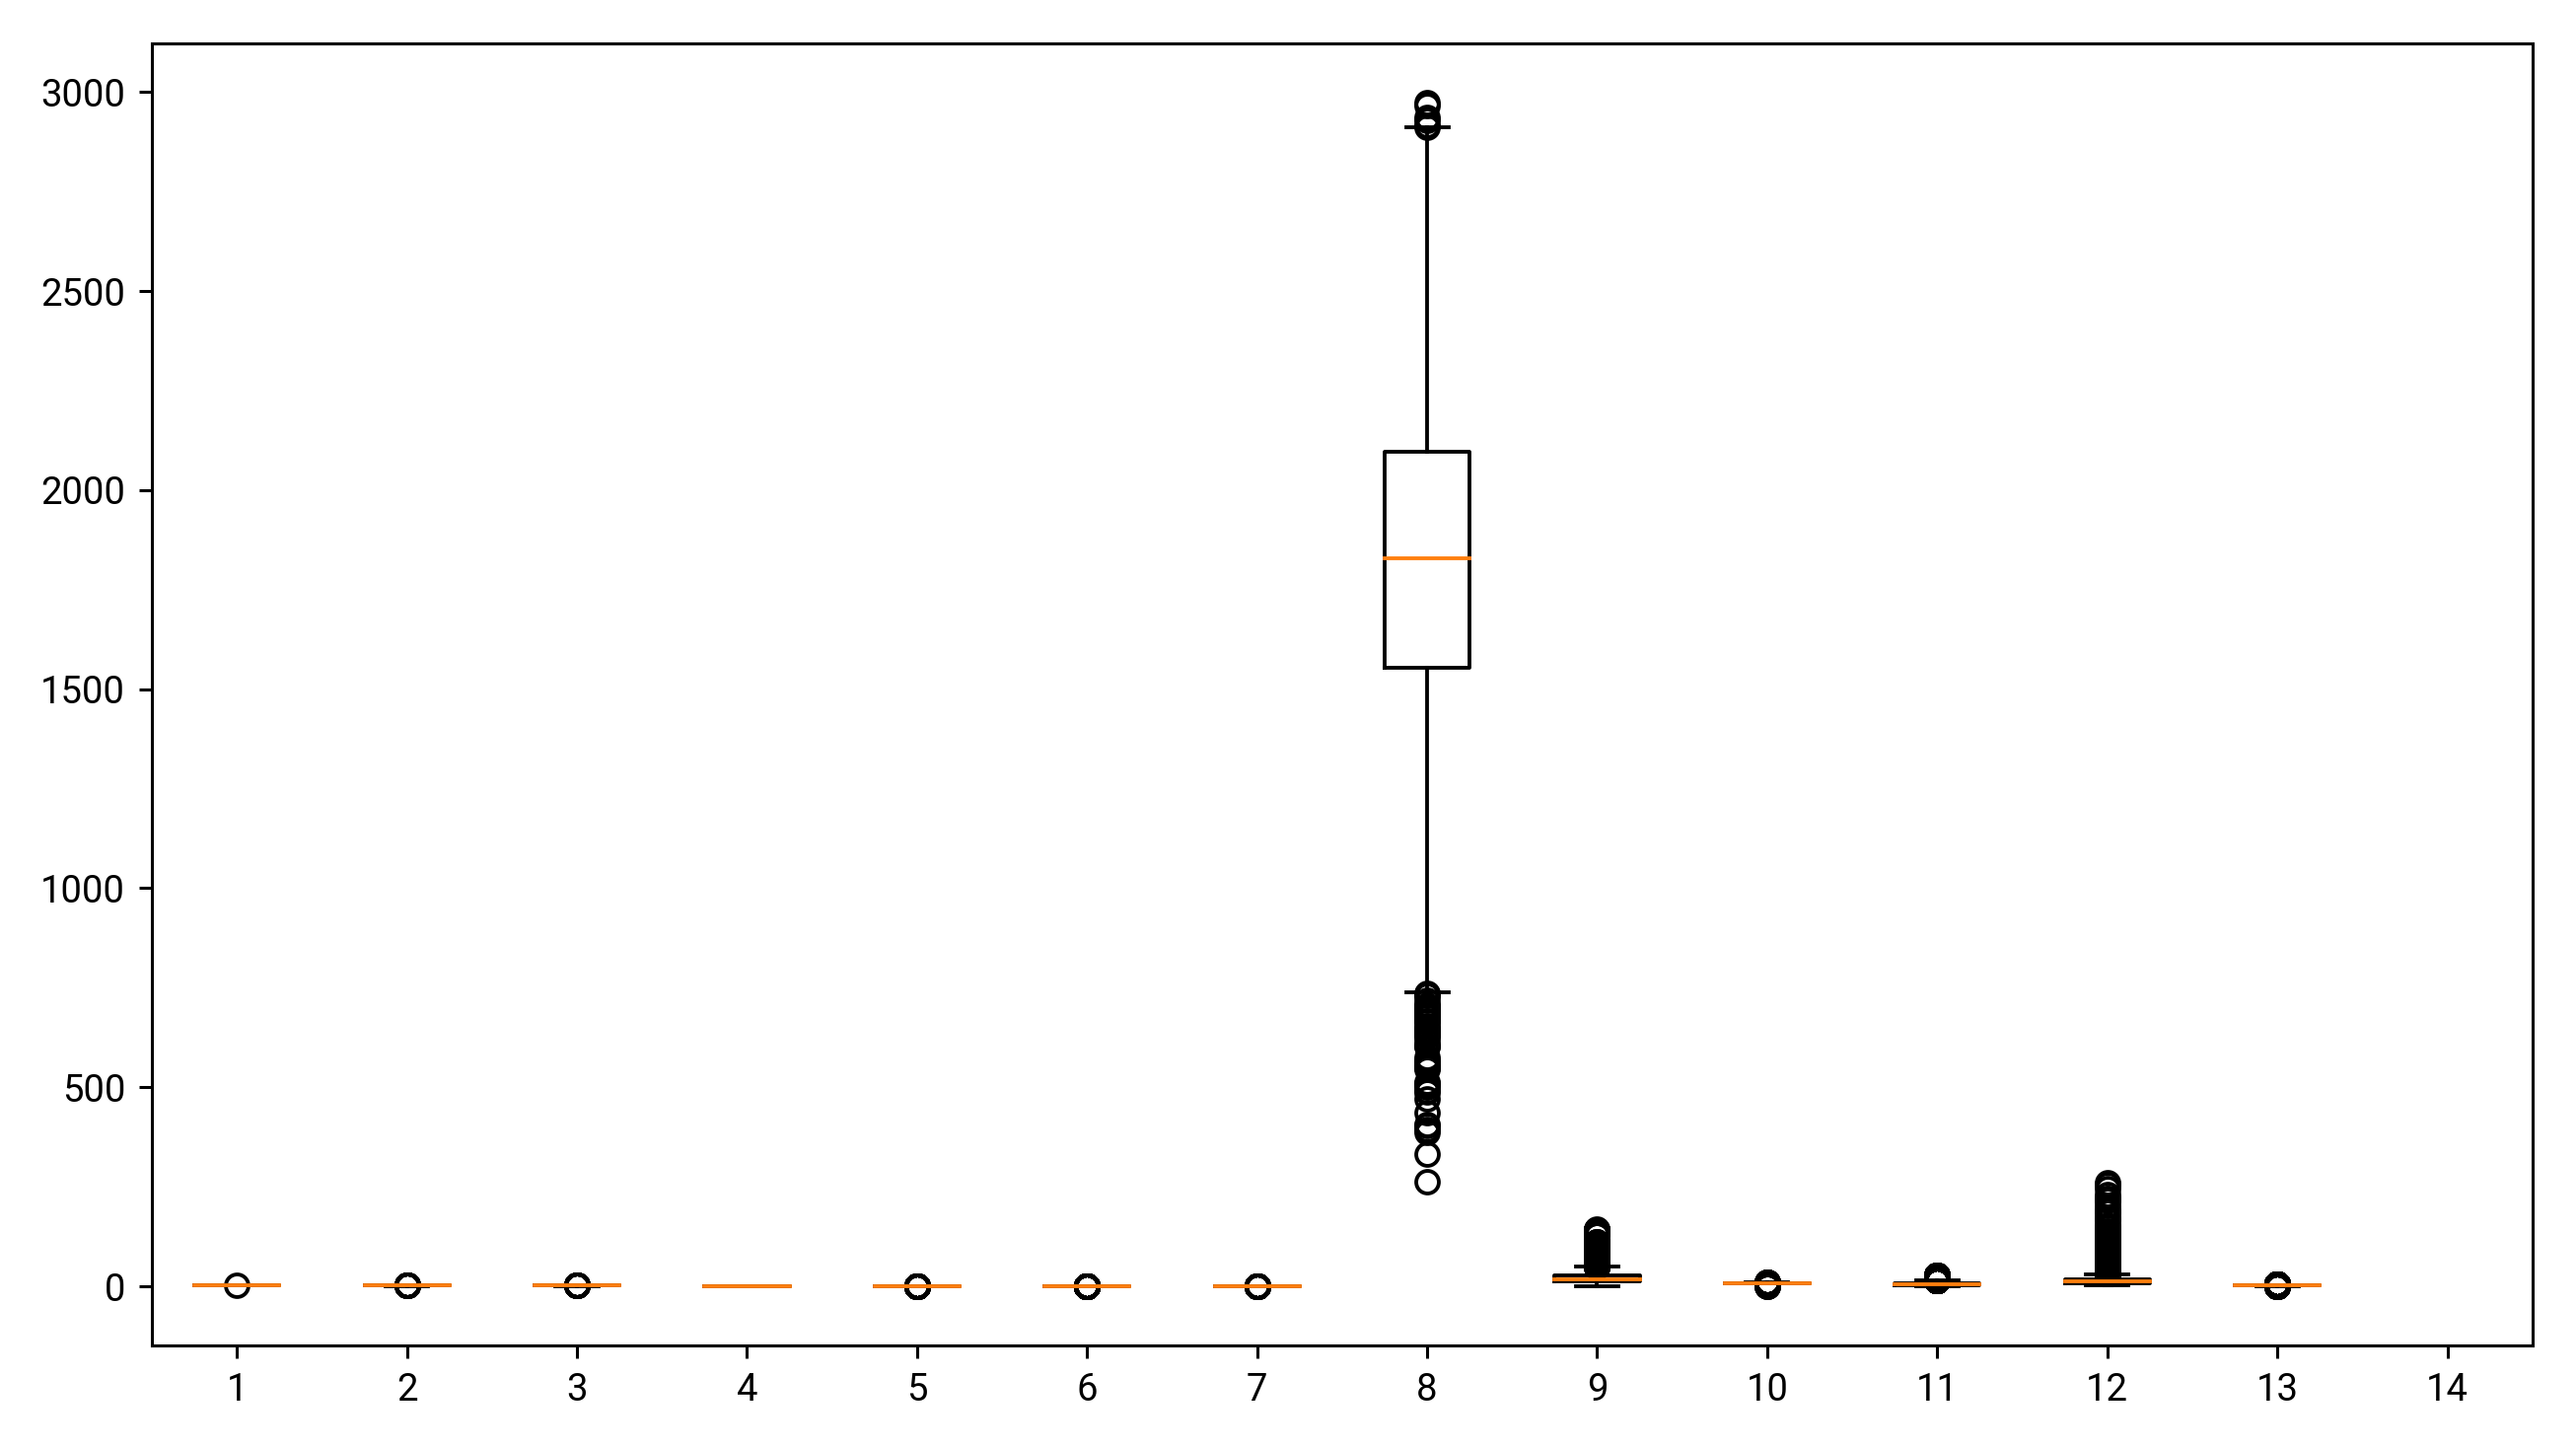

C:\Users\laurent\Miniconda3\envs\auto-ls-svm-env\lib\site-packages\numpy\lib\function_base.py:4269: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
C:\Users\laurent\Miniconda3\envs\auto-ls-svm-env\lib\site-packages\matplotlib\cbook.py:2066: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = np.compress(x <= hival, x)
C:\Users\laurent\Miniconda3\envs\auto-ls-svm-env\lib\site-packages\matplotlib\cbook.py:2073: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = np.compress(x >= loval, x)
C:\Users\laurent\Miniconda3\envs\auto-ls-svm-env\lib\site-packages\matplotlib\cbook.py:2081: RuntimeWarning: invalid value encountered in less
  np.compress(x < stats['whislo'], x),
C:\Users\laurent\Miniconda3\envs\auto-ls-svm-env\lib\site-packages\matplotlib\cbook.py:2082: RuntimeWarning: invalid value encountered in greater
  np.compress(x > stats['whishi'], x)


In [26]:
plt.boxplot([dist[ds] for ds in dist.keys()]);

In [27]:
sz = {ds: data[ds]['data'].shape[1] for ds in data.keys()}

C:\Users\laurent\Miniconda3\envs\auto-ls-svm-env\lib\site-packages\numpy\lib\function_base.py:4011: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


<IPython.core.display.Javascript object>


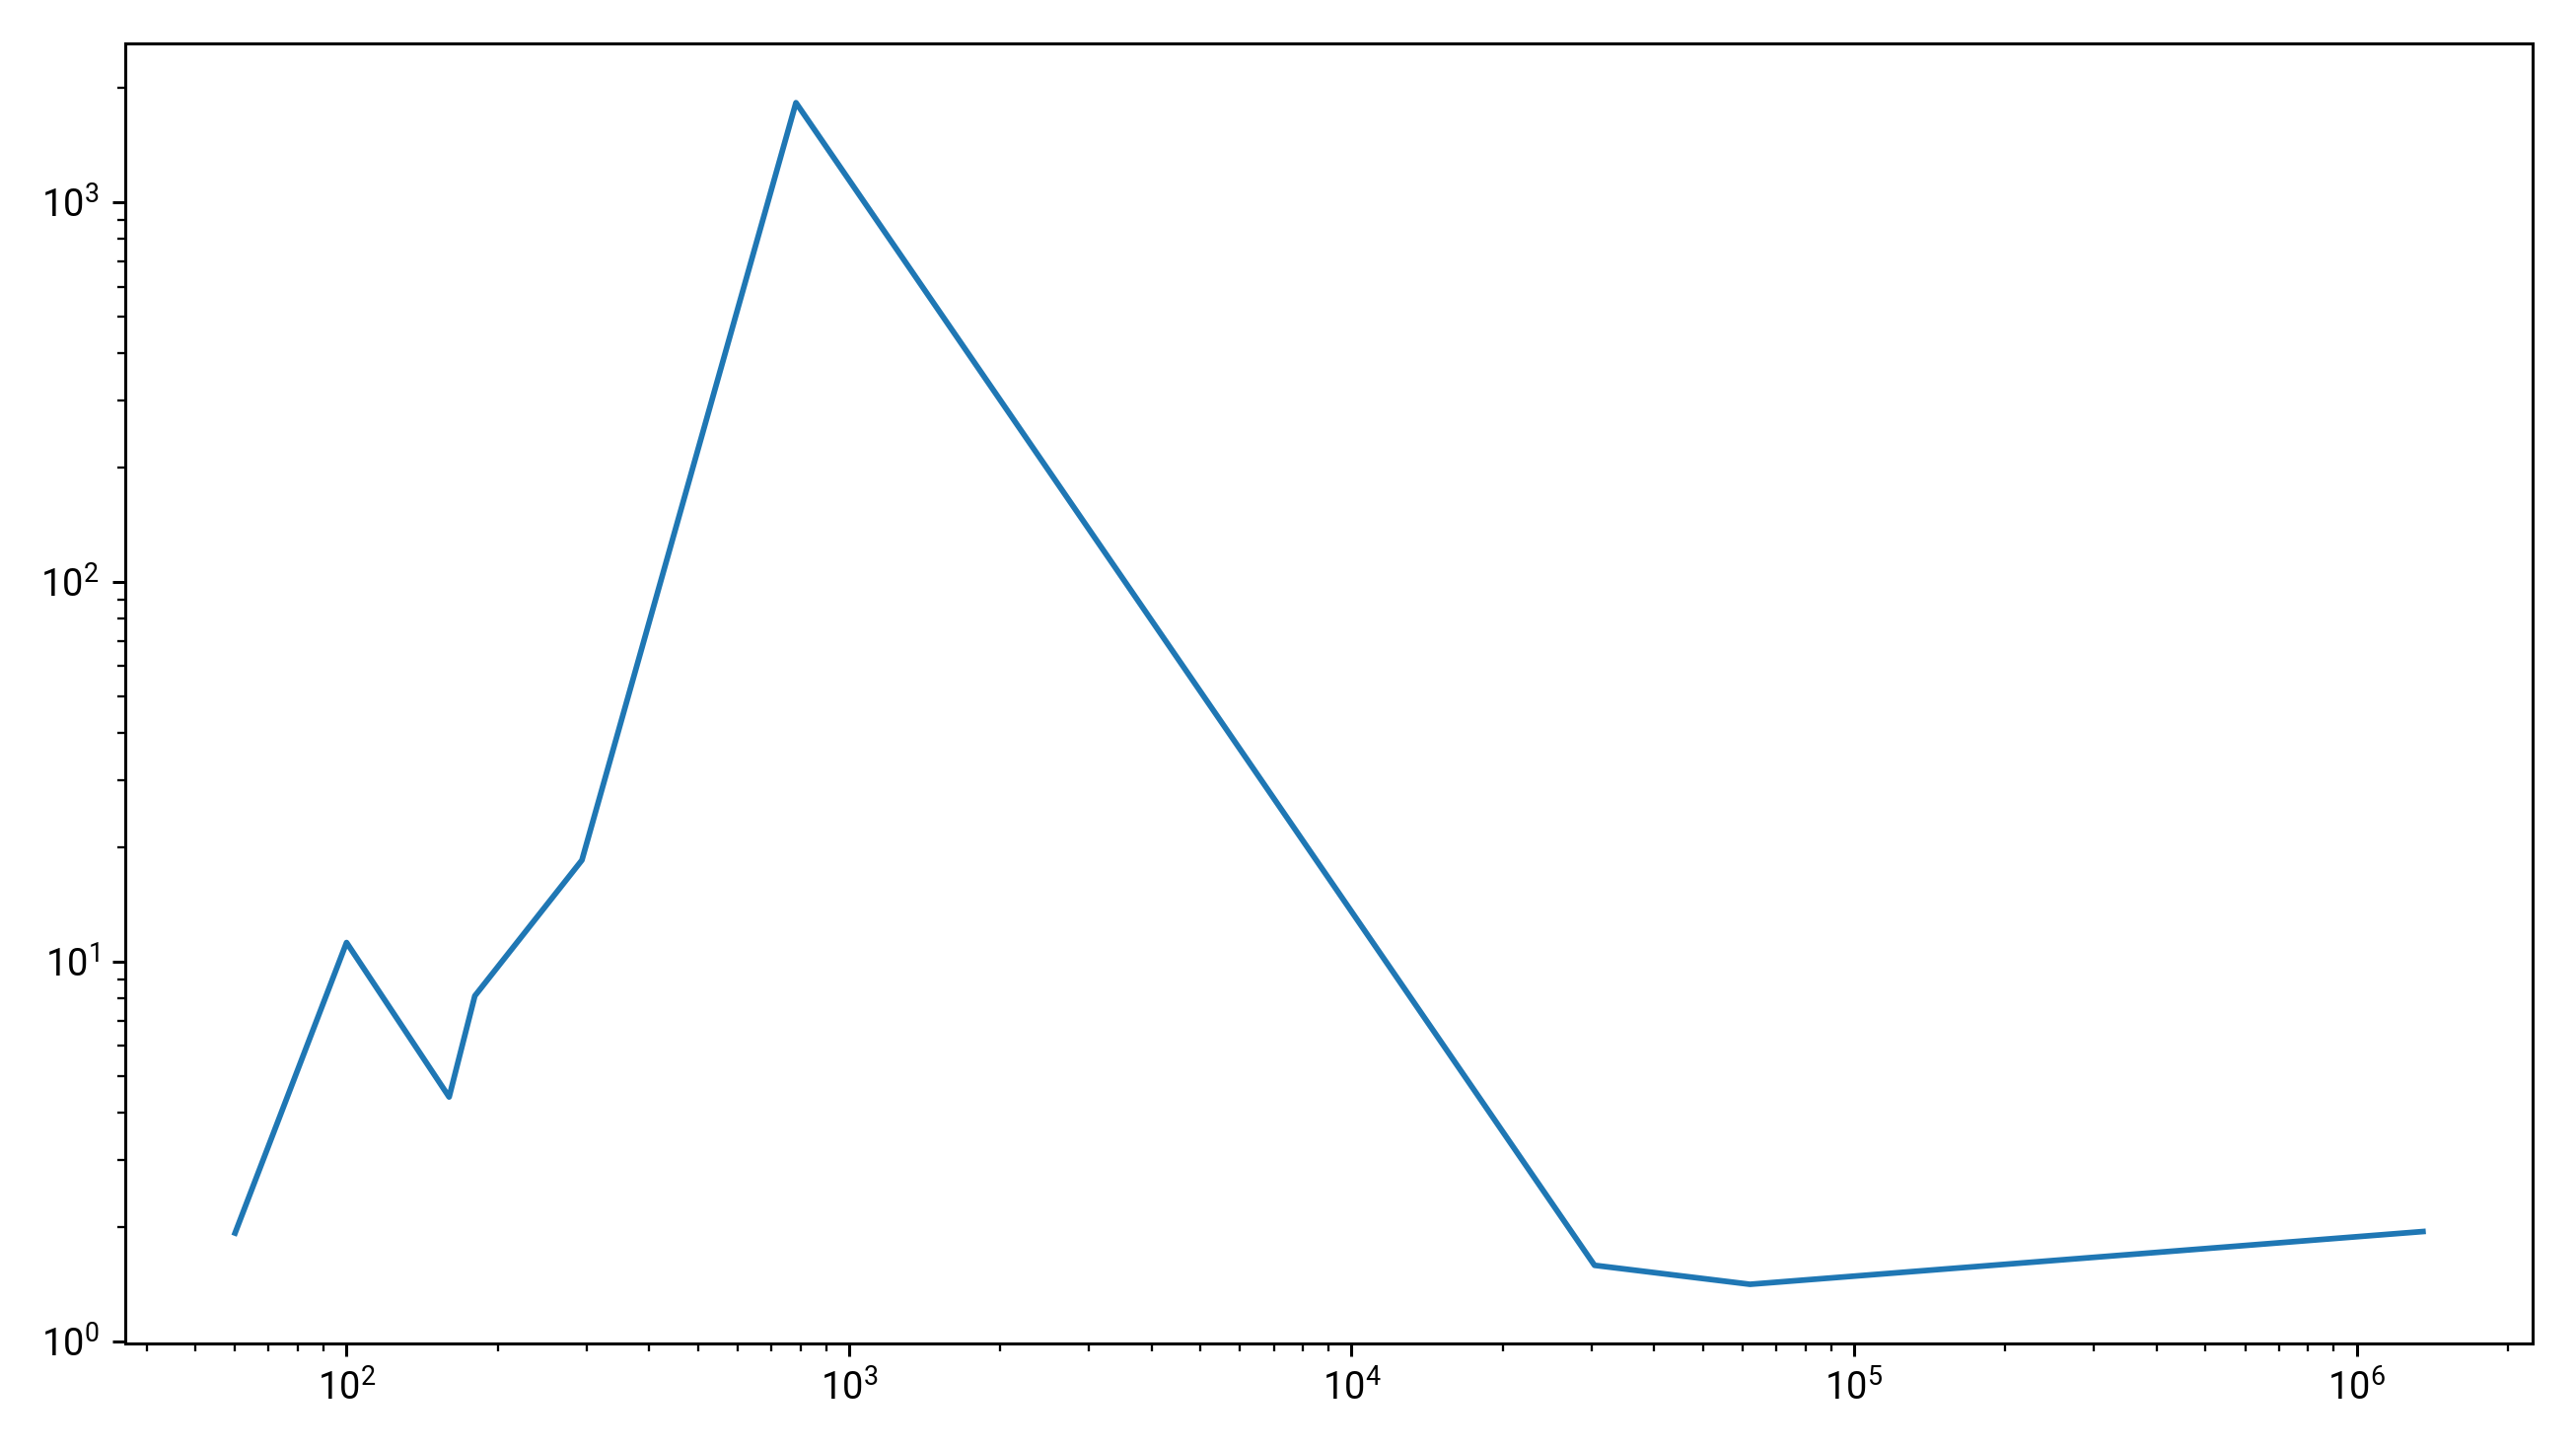

In [28]:
x = [sz[ds] for ds in reversed(datasets) if ds in dist.keys() and sz[ds] > 1]
y = [np.median(dist[ds]) for ds in reversed(datasets) if ds in dist.keys() and sz[ds] > 1]
plt.loglog(x, y);

In [29]:
y

[nan,
 1.9297347321664686,
 11.234148949565162,
 4.4029718541774354,
 8.1278841035044298,
 18.514615469233991,
 1829.5734439455027,
 1.5867774051323804,
 1.4142167836116923,
 1.9473096202720197]

In [30]:
x

[8, 60, 100, 160, 180, 294, 784, 30438, 62061, 1355191]

In [31]:
np.linalg.norm(np.random.randn(10,3) - np.random.randn(10,3), axis=1)

array([ 1.63955958,  1.97694264,  1.97201312,  2.63784627,  4.46255324,
        1.68905085,  0.65122902,  1.43629043,  2.51830794,  1.08501139])